# CoronaHack Chest X-Ray-Dataset

The [CoronaHack Chest X-Ray](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset) dataset is a collection of chest x-ray images. The goal is to classify a chest x-ray image as healthy or not. A chest x-ray that is not healthy presents signs of pneumonia. Infected patients suffer due to various reasons (e.g., bacteria or virus infection), but we limit the scope of the problem and formulate it as a binary classification task.

In this Notebook, you will load the model you have trained using the provided `coronahack.py` Python script, and predict whether the X-Ray images in the test set are healthy or not.

<img src="images/banner.jpg" width="500" style="margin-left: auto; margin-right: auto;">

### Attribution

The author of the [CoronaHack Chest X-Ray](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset) dataset is [Praveen Govi](https://www.kaggle.com/praveengovi). The author collected the data from https://github.com/ieee8023/covid-chestxray-dataset and Chest X-Ray Kaggle dataset.

Image by <a href="https://unsplash.com/@cdc?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">CDC</a> on <a href="https://unsplash.com/s/photos/covid-19?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Imports

In this section we import the packages we need for this example. It's a good habit to gather your imports in a single place, so in this cell we import everything we need to create our predictions.

In [1]:
import torch
import torchmetrics
import torchvision.transforms as transforms
import pandas as pd

from pathlib import Path

from PIL import Image
from torch.utils.data import DataLoader

from coronahack import CoronaHackDataset, eval_step, METADATA_PATH

# Load and preprocess data

In this section, we load and process the dataset to get it in a ready-to-use form by the model. First, let us load and visualize the data. The next cell provides the path to an image and specifies its size. We will load it as a 256x256 image, so it does not take too much space in our Notebook UI.

> Note that this is an unhealthy X-Ray image. You can tell that by looking at its filename, which implies a bacterial infection.

In [2]:
img_path = Path("data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person139_bacteria_662.jpeg")
img_size = (256, 256)

Now that we have specified the path to an image and it size, we can use the `Pillow` library to load and visualize it:

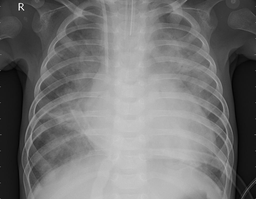

In [3]:
img = Image.open(img_path)
img.thumbnail(img_size, Image.ANTIALIAS)
img.show()

So far so good, but the type of this image is a `JpegImageFile`. You can see that using Python's `type` command:

In [4]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

We cannot feed this type to our model. For this, we need to transform the `JpegImageFile` to a `Tensor`. The following transformation has four steps:
1. Crop the original image file in a 224x224 image
2. Transform every X-Ray image into a grayscale image
3. Convert every image file to a `Tensor`
4. Normalize every image using the ImageNet statistics

In [5]:
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

img_tensor = tfms(img)

We have successfully transformed the image into a `Tensor`:

In [6]:
print(f"The shape of the image Tensor is: {list(img_tensor.shape)}")

The shape of the image Tensor is: [1, 224, 224]


We see that the shape of the image is `[1, 224, 224]`. That means that our image has one color channel (i.e., it's a greyscale image) and its width and height is 224 pixels.

# Load the Model for Inference

We are now ready to load the model we've trained using the `coronahack.py` Python script. The model is stored in this location:

`$HOME/pytorch-distributed/<name-of-distributed-job>/model.pt`

This way, if you want to start a new distributed job from this Notebook server you won't lose the current saved model. This permits you to work iteratively.

> To load the model please provide a valid value for the `job_name` variable.

In [7]:
job_name = "<job-name>"
home = Path.home()
model_path = home/"pytorch-distributed"/job_name/"model.pt"

In [8]:
model = torch.jit.load(model_path)

We are now ready to use our model to get a prediction. The model returns two scores: one for the healthy class and one for the undhealthy class. To turn these scores into a valid probability distribution we need a Softmax layer. 

In [9]:
softmax_layer = torch.nn.Softmax(dim=1)

Let's see now if our model classifies correctly this X-Ray:

In [10]:
# expand the image Tensor to account for the batch dimension
img_tensor.unsqueeze_(0)
prediction = model(img_tensor)
output = softmax_layer(prediction)

In [11]:
category = "healthy" if torch.argmax(output).item() == 0 else "unhealthy"
print(f"This X-Ray depicts an '{category}' example.")

This X-Ray depicts an 'healthy' example.


# Calculate the Accuracy of the Model

Getting a prediction on one image is great, but it does not tell us much about the preformance of the model. To have a better idea we need to evaluate it on the whole test dataset.

The following cells leverage the code that is already present in the `coronahack.py` Python file, to create a test `DataLoader` and calculate the the accuracy of the model on the whole test dataset.

> Note that if you have not downloaded the full CoronaHack dataset, the test set contains only 4 images. So, it cannot be used to calculate the performance of the model in a real-world scenario. However, having a robust model is not the purpose of this tutorial, so we can still experiment.

In [12]:
# create a new `Target` variable to encode the `Normal` and `Pneumonia` classes
df = pd.read_csv(METADATA_PATH)
df["Target"] = df["Label"].astype("category").cat.codes

In [13]:
# keep only the metadata for the test dataset
test_df = df[df["Dataset_type"] == "TEST"]
test_df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Target
10,5619,person139_bacteria_662.jpeg,Pnemonia,TEST,NaN,bacteria,1
15,5614,person140_bacteria_667.jpeg,Pnemonia,TEST,NaN,bacteria,1
20,5579,person154_bacteria_728.jpeg,Pnemonia,TEST,NaN,bacteria,1
24,5472,NORMAL2-IM-0207-0001.jpeg,Normal,TEST,NaN,NaN,0


In [14]:
data_path = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"

# create the test DataLoade
test_dataset = CoronaHackDataset(test_df, data_path, tfms, "test")
test_dataloader = DataLoader(test_dataset, batch_size=2)

# define the loss function and the accuracy metric
criterion = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy()

# specify the device (i.e., CPU or GPU)
device = torch.device("cpu")

In [15]:
eval_step(model, test_dataloader, criterion, device, {"metric": metric})

Loss = 0.5498602390289307
Accuracy = 1.0
